# PIPELINE FOR SINGLE RASTER

# §0 - Read-in and set-up
---

## 0.1 - file read-in

In [1]:
from sav_extract import sav_extract
filename='iris2model.sav'
iris2model=sav_extract(filename)

Your file iris2model.sav contains an inversion of a single raster and will be returned as a numpy.record...
...with the required structure


## 0.2 - Initial data read-in and trim

In [2]:
# need to completely rework this into inline functions instead of reading it in (later in project)


from data_extract import tag_extract, kpeak_ind_extract, trimmed_rows, data_trim

wavelength  = tag_extract(iris2model,'wl') # need this one first
iris_cal    = tag_extract(iris2model,'iris_cal') # then this one to get trimmed rows from kpeak frame

kpeak_ind   = kpeak_ind_extract(wavelength) # isolate the wavelength index closest to Mg II k peak
frame       = iris_cal[kpeak_ind,...] # create a frame at this peak wavelength, where FL is most visible
trimmed_rows= trimmed_rows(frame) # cuts FOV to only include observed data, not zeros at top and bottom (returns list of top and bottom row)

del frame # it has served its purpose to get trimmed rows, now delete to save confusion pre-trim
del wavelength

iris_cal    = data_trim(iris_cal, trimmed_rows,'iris_cal')

iris_cal has successfully been trimmed to (217, 183, 32)


## 0.3 - Initial frame creation

In [3]:
frame=iris_cal[kpeak_ind]

# §1 - Frame cleaning function list
---

## 1.1 - Slit row extraction function

In [4]:
import numpy as np
import scipy.stats as stats

def slit_row_extract(frame):
    '''
    Extract the index of the row with the slit in it from monochromatic image.
    Works by getting the row index of the min val in each col and taking the most common
    row value from that list
    '''
    slit_rows=[]
    for col in range(frame.shape[1]):
        slit_rows.append(np.argmin(frame[:,col]))
    slit_row=int(stats.mode(slit_rows)[0])
    return slit_row

## 1.2 - Threshold extraction function (using hist)

In [5]:
import numpy as np # explicitly state package dependencies for each sep function
from scipy.signal import find_peaks

def thresh_extract(frame,slit_row):
    '''
    Extract flat threshold frame for filament sep from k3 monochromatic frame.
    It does this by raising slit vals to a max value so the first trough of histogram 
    is roughly the threshold between filamenty and quiet sun.
    (Only tested for quiet sun filament obs as of 21/09/2020)
    '''
    ### raise slit vals to max for hist peaks
    frame[slit_row,:]=np.amax(frame) 
    frame[slit_row-1,:]=np.amax(frame)

    ### then do find peaks for thresh here:
    frame_linear=np.reshape(frame,-1)
    bin_number=int(len(frame_linear)/80) # 80 decided empirically to give consistently good peaks
    hist,bins = np.histogram(frame_linear, bins = bin_number) # iteratively decided on 70 bins
    bin_centres = 0.5*(bins[1:]+bins[:-1])

    peaks, _ = find_peaks(-hist) # find troughs
    index=peaks[0] # since bin size is so big, first trough corresponds to post-FL dip.
    thresh=bin_centres[index] 
    frame[frame>thresh]=0
    return frame


## 1.3 - Binary mask extraction function

In [6]:
import numpy as np
from scipy.signal import medfilt

def bin_mask_extract(thresh_frame,slit_row=None):
    '''
    Extracts binary mask array-like 1s for filament, 0s for quiet sun from post-thresh frame.
    It does this using a basic median filter that cleans out rough edges of post-thresh frame.
    For border creation, don't give slit_row keyword (COSMETIC)
    For index sep and further data reduction, give slit_row keyword (DATA REDUCTION)
    '''
    bin_mask=np.where(thresh_frame>0,1,0)
    if slit_row is None: # COSMETIC no slits nan'd to create line border
        bin_mask=medfilt(bin_mask,5) 
        return bin_mask # COSMETIC
    else:
        # DATA REDUCTION slit rows are nan'd to stop slit row values (which are neither FL or QS) being wronlgy counted as such
        # need to give slit row value as explicit argument when calling function
        bin_mask[slit_row,:]=100 
        bin_mask[slit_row-1,:]=100
        bin_mask=np.where(bin_mask>1,np.nan,bin_mask)
        bin_mask=medfilt(bin_mask,5) 
        return bin_mask # Further DATA REDUCTION

## 1.4 - Mask border extraction function(s)

In [7]:
from matplotlib.collections import LineCollection

def get_all_boundary_edges(bool_img):
    '''
    Get a list of all edges
    (where the value changes from 'True' to 'False') in the 2D image.
    Return the list as indices of the image.
    '''
    ij_boundary = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            ij_boundary.append(np.array([[i, j+1],
                                         [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            ij_boundary.append(np.array([[i+1, j],
                                         [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            ij_boundary.append(np.array([[i, j],
                                         [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            ij_boundary.append(np.array([[i, j],
                                         [i, j+1]]))
    if not ij_boundary:
        return np.zeros((0, 2, 2))
    else:
        return np.array(ij_boundary)

def close_loop_boundary_edges(xy_boundary, clean=True):
    '''
    Connect all edges defined by 'xy_boundary' to closed 
    boundary lines.
    If not all edges are part of one surface return a list of closed 
    boundaries is returned (one for every object).
    '''
    boundary_loop_list = []
    while xy_boundary.size != 0:
        # Current loop
        xy_cl = [xy_boundary[0, 0], xy_boundary[0, 1]]  # Start with first edge
        xy_boundary = np.delete(xy_boundary, 0, axis=0)

        while xy_boundary.size != 0:
            # Get next boundary edge (edge with common node)
            ij = np.nonzero((xy_boundary == xy_cl[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                xy_cl.append(xy_cl[0])
                break

            xy_cl.append(xy_boundary[i, (j + 1) % 2, :])
            xy_boundary = np.delete(xy_boundary, i, axis=0)

        xy_cl = np.array(xy_cl)

        boundary_loop_list.append(xy_cl)

    return boundary_loop_list

def plot_world_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    ij_boundary = get_all_boundary_edges(bool_img=bool_img)
    xy_boundary = ij_boundary - 0.5
    xy_boundary = close_loop_boundary_edges(xy_boundary=xy_boundary)
    cl = LineCollection(xy_boundary, **kwargs)
    ax.add_collection(cl)

# §2 - Data reduction function list
---

## 2.1 - Bad pixel extraction

In [8]:
import numpy as np

def bad_pix_extract(uncertainty):
    '''
    Iterates pix by pix basis through temp uncertainty and makes a list of tuples with non finite uncertainty.
    These pixels should be omitted before pix region assignment.
    (only need to do for temp as all model variables have same (bad) fitting for each pixel)
    '''
    bad_pix=[]
    local_temp_unc=uncertainty[0,...]
    test_array=np.zeros(local_temp_unc.shape[0])

    for tuple_index,_ in np.ndenumerate(local_temp_unc[0,...]): # goes through pix index pix by pix in 2d
        temp_ltau=local_temp_unc[:,tuple_index[0],tuple_index[1]] #for all values of ltau but single pix
        finite_test_array=np.isfinite(temp_ltau,test_array)
        if np.any(finite_test_array==0):
            bad_pix.append(tuple_index) 
    print(f'There are {len(bad_pix)} poorly-fitted pixels in this observation')
    return bad_pix 

## 2.2 - Pixel region assignment - omitting slit and bad pix

In [9]:
import numpy as np

def pix_region_assign(bin_mask,bad_pix):
    '''
    Takes input of binary mask with slit values as nans and returns two lists as index tuples 
    for pixels belonging to fl and qs regions (in that order) only if all pix are accounted for.
    Slit pixels are added to a seperate list but not returned. This is created to ensure all 
    pixels of bin mask are accounted for but serve no further purpose.
    '''
    fl_pix=[]
    qs_pix=[]
    empty_pix=[] # want to fill this with tuple indices for slit and bad pixels combined
    for pix_ind, pix_val in np.ndenumerate(bin_mask):
        
        if pix_ind in bad_pix:
            empty_pix.append(pix_ind)
        else:
            if pix_val==0:
                qs_pix.append(pix_ind)
            if pix_val==1:
                fl_pix.append(pix_ind)
            if np.isnan(pix_val)==True:
                empty_pix.append(pix_ind)

    if len(fl_pix+qs_pix+empty_pix)==len(np.reshape(bin_mask,-1)):
        print(f'All binary mask pixels successfully accounted for...\nThere are {len(empty_pix)} pixels identified as slit pixels and/or poorly-fitting pixels and have been removed from this observation. \nLeaving {len(fl_pix)} filament region pixels and {len(qs_pix)} quiet sun pixels from the original {bin_mask.shape[0]*bin_mask.shape[1]} pixel binary array')
        return fl_pix,qs_pix        
    else:
        print('Not all binary pixels are accounted for...')
        return 

## 2.3 - Data and unc mean

In [10]:
import numpy as np

def data_mean_extract(model_dat_cube,pixels):
    '''
    Creates arrays for model means and their uncertainties for QS/Fl seperately
    (model is either temp or ne, pixels is eiher qs or fl list)
    '''
    model_sum=np.zeros(model_dat_cube.shape[0]) # makes zero array like ltau
    for tuple_index in pixels:
        model_ltau=model_dat_cube[:,tuple_index[0],tuple_index[1]] #for all values of ltau but single pix
        model_sum=model_sum+model_ltau
    model_mean=model_sum/len(pixels)    
    return model_mean

---
# Pipeline - this is the bit that needs to be scaled for multi obs, everything above should remain fixed
---

## §0 - Main model variables assignment

In [11]:
# tag extract and data trim

ltau        = tag_extract(iris2model,'ltau')
ltau        = data_trim(ltau,trimmed_rows,'ltau')

model       = tag_extract(iris2model,'model')
model       = data_trim(model,trimmed_rows,'model')

uncertainty = tag_extract(iris2model,'uncertainty')
uncertainty = data_trim(uncertainty,trimmed_rows,'uncertainty')

# model variable and unc assignment

temp, temp_unc= model[0,...],  uncertainty[0,...]
ne,   ne_unc  = model[3,...],  uncertainty[3,...]

ltau has successfully been trimmed to (37,)
model has successfully been trimmed to (4, 37, 183, 32)
uncertainty has successfully been trimmed to (4, 37, 183, 32)


## §1 - Frame cleaning - only for linegraphs

In [12]:
# already have frame from §0 at the very start of notebook - keep this consistent for mulit scaling, need to finish completely all experimenting like chi2 etc before making functions in .py scripts

slit_row=slit_row_extract(frame)
thresh_frame=thresh_extract(frame,slit_row)
bin_mask_data=bin_mask_extract(thresh_frame,slit_row=slit_row)

## §2 - Data reduction for linegraphs

In [13]:
bad_pix=bad_pix_extract(uncertainty)
fl_pix,qs_pix=pix_region_assign(bin_mask_data,bad_pix)

fl_temp,fl_temp_unc=data_mean_extract(temp,fl_pix),data_mean_extract(temp_unc,fl_pix)
qs_temp,qs_temp_unc=data_mean_extract(temp,qs_pix),data_mean_extract(temp_unc,qs_pix)
fl_ne,fl_ne_unc=data_mean_extract(ne,fl_pix),data_mean_extract(ne_unc,fl_pix)
qs_ne,qs_ne_unc=data_mean_extract(ne,qs_pix),data_mean_extract(ne_unc,qs_pix)

There are 48 poorly-fitted pixels in this observation
All binary mask pixels successfully accounted for...
There are 106 pixels identified as slit pixels and/or poorly-fitting pixels and have been removed from this observation. 
Leaving 1705 filament region pixels and 4045 quiet sun pixels from the original 5856 pixel binary array


<ErrorbarContainer object of 3 artists>

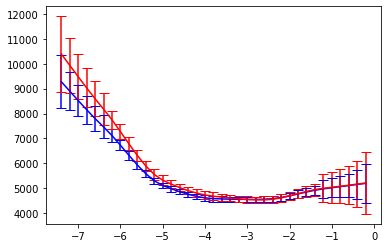

In [14]:
import matplotlib.pyplot as plt

plt.errorbar(ltau,fl_temp,yerr=fl_temp_unc,capsize=5,color='b')
plt.errorbar(ltau,qs_temp,yerr=qs_temp_unc,capsize=5,color='r')